## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import pymc as pm
import arviz as az
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
# Folder name
folder = 'Data'

# Read each file
artists = pd.read_csv(f'{folder}/artists.dat', sep='\t')
tags = pd.read_csv(f'{folder}/tags.dat', sep='\t', encoding='latin-1')
user_artists = pd.read_csv(f'{folder}/user_artists.dat', sep='\t')
user_friends = pd.read_csv(f'{folder}/user_friends.dat', sep='\t')
user_taggedartists = pd.read_csv(f'{folder}/user_taggedartists.dat', sep='\t')
user_taggedartists_timestamps = pd.read_csv(f'{folder}/user_taggedartists-timestamps.dat', sep='\t')


In [3]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [4]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [5]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [6]:
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [7]:
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [8]:
user_taggedartists_timestamps.head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


## EDA

In [9]:
# Merge user_artists with artists
ua_artists = pd.merge(user_artists, artists, left_on='artistID', right_on='id', how='left')

# Merge user_taggedartists with tags and artists
uta_tags = pd.merge(user_taggedartists, tags, left_on='tagID', right_on='tagID', how='left')
uta_full = pd.merge(uta_tags, artists, left_on='artistID', right_on='id', how='left')

ua_artists.head()

,userID,artistID,weight,id,name,url,pictureURL
0,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
1,2,52,11690,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
2,2,53,11351,53,Air,http://www.last.fm/music/Air,http://userserve-ak.last.fm/serve/252/251119.jpg
3,2,54,10300,54,Hooverphonic,http://www.last.fm/music/Hooverphonic,http://userserve-ak.last.fm/serve/252/40553471...
4,2,55,8983,55,Kylie Minogue,http://www.last.fm/music/Kylie+Minogue,http://userserve-ak.last.fm/serve/252/12740835...


In [10]:
uta_tags.head()

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo
2,2,52,18,1,4,2009,electronic
3,2,52,21,1,4,2009,trip-hop
4,2,52,41,1,4,2009,female vovalists


In [11]:
uta_full.head()

,userID,artistID,tagID,day,month,year,tagValue,id,name,url,pictureURL
0,2,52,13,1,4,2009,chillout,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
1,2,52,15,1,4,2009,downtempo,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
2,2,52,18,1,4,2009,electronic,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
3,2,52,21,1,4,2009,trip-hop,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...
4,2,52,41,1,4,2009,female vovalists,52.0,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...


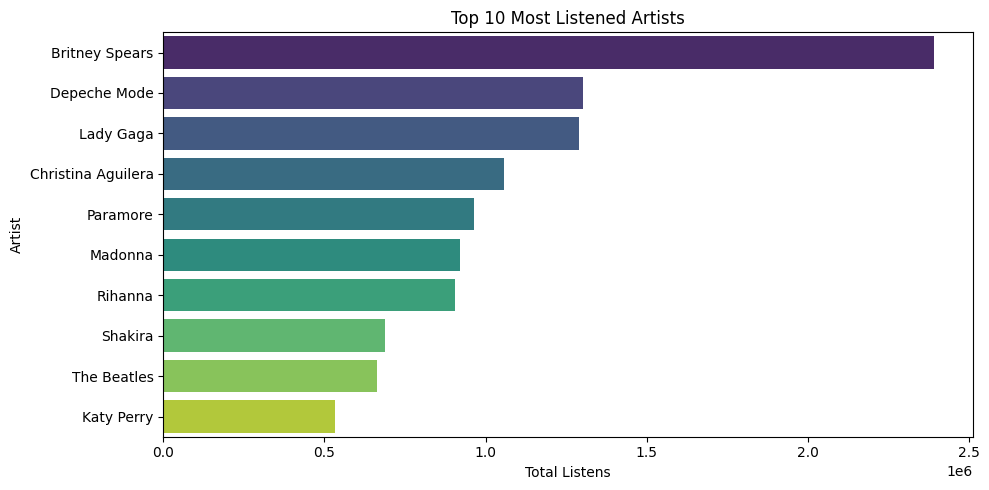

In [12]:
top_artists = ua_artists.groupby('name')['weight'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Most Listened Artists')
plt.xlabel('Total Listens')
plt.ylabel('Artist')
plt.tight_layout()
plt.show()

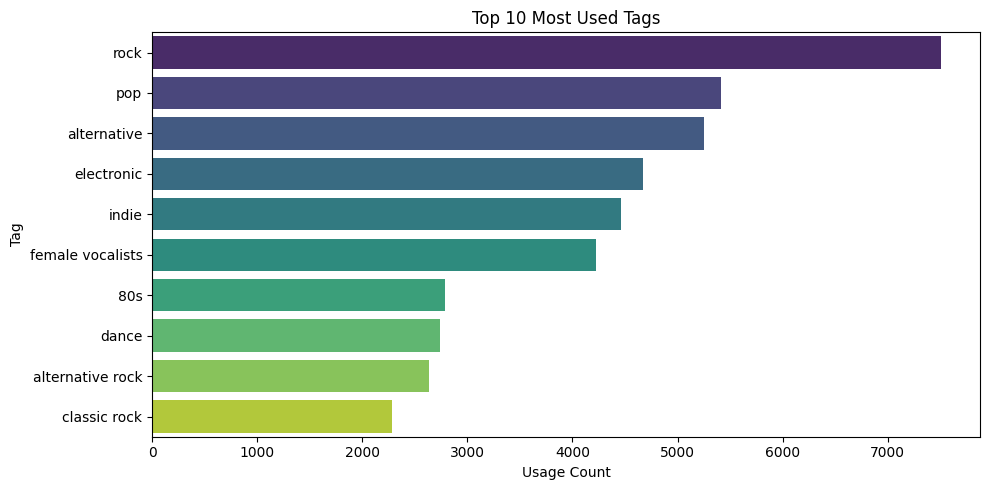

In [13]:
top_tags = uta_full['tagValue'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title('Top 10 Most Used Tags')
plt.xlabel('Usage Count')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

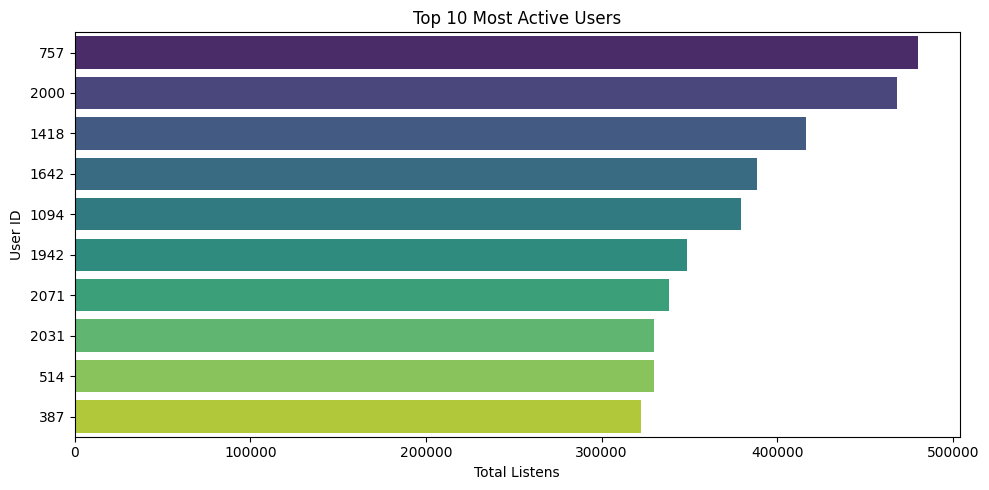

In [14]:
user_activity = ua_artists.groupby('userID')['weight'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=user_activity.values, y=user_activity.index.astype(str), palette='viridis')
plt.title('Top 10 Most Active Users')
plt.xlabel('Total Listens')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

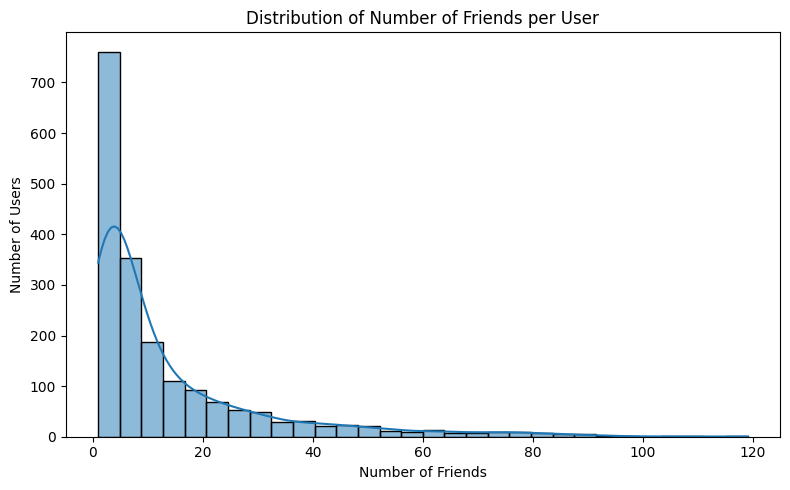

In [15]:
friend_counts = user_friends['userID'].value_counts()

plt.figure(figsize=(8,5))
sns.histplot(friend_counts, bins=30, kde=True)
plt.title('Distribution of Number of Friends per User')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


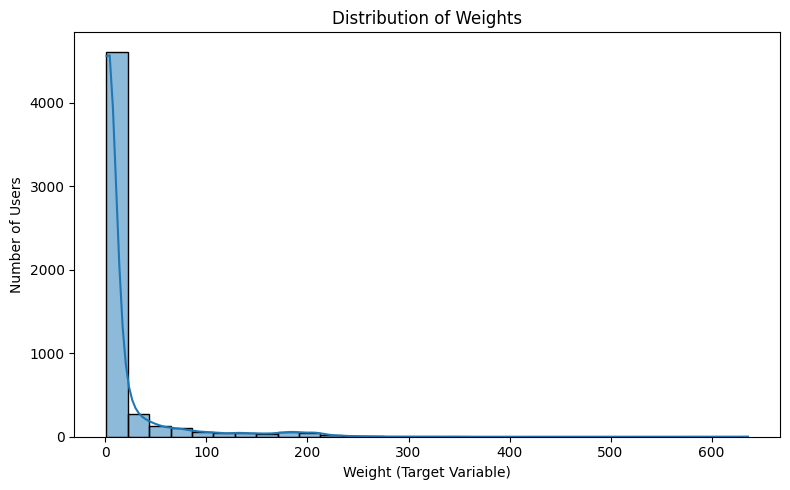

In [16]:
weights = ua_artists['weight'].value_counts()

plt.figure(figsize=(8,5))
sns.histplot(weights, bins=30, kde=True)
plt.title('Distribution of Weights')
plt.xlabel('Weight (Target Variable)')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

Weights are heavily right skewed, indicating that a log transformation may be appropriate to reduce skewness.

## Modeling

### Data prep

In [17]:
# Map user and artist IDs to indices
user_ids = user_artists['userID'].unique()
artist_ids = user_artists['artistID'].unique()
user_map = {u: i for i, u in enumerate(user_ids)}
artist_map = {a: i for i, a in enumerate(artist_ids)}

# Create index columns
user_artists['user_idx'] = user_artists['userID'].map(user_map)
user_artists['artist_idx'] = user_artists['artistID'].map(artist_map)

# Log-transform the weights (target) to reduce skew
user_artists['log_weight'] = np.log1p(user_artists['weight'])

# Prepare arrays for modeling
user_idx = user_artists['user_idx'].values
artist_idx = user_artists['artist_idx'].values
ratings = user_artists['log_weight'].values

### Train Test split

In [18]:
# Split indices for train/test
train_idx, test_idx = train_test_split(np.arange(len(ratings)), test_size=0.2, random_state=42)

# Training data
train_user_idx = user_idx[train_idx]
train_artist_idx = artist_idx[train_idx]
train_ratings = ratings[train_idx]

# Test data
test_user_idx = user_idx[test_idx]
test_artist_idx = artist_idx[test_idx]
test_ratings = ratings[test_idx]

### Build and Fit Bayesian Probabalistic Matrix Factorization (BPMF) model

#### Hyperpriors, latent factor matrices, predictions, noise, and likelihood
- mu_u and mu_v are the means for the user and item (artist) latent factors
    - vector of length K (number of latent features)
    - drawn from normal dist with mean 0 and stdv 1 (Standard Normal)<br>
- sigma_u and sigma_v are the stdevs for the user and item latent factors
    - drawn from half-normal dist (only positive values)<br>
- U: latent factor matrix for users, drawn from normal dist with mean mu_u and stdev sigma_u
- V: latent factor matrix from artists, drawn from normal dist with mean mu_v and stdev sigma_v
- dot_product: model's predicted rating for each (user, artist) pair
- sigma: standard deviation of observation noise learned from the data
- R_obs: likelihood
    - observed rating for each (user, artist) pair is drawn from a normal distribution centered at model's prediction (mu = dot_product), with some unknown noise (sigma)

#### ADVI (Automatic Differentiation Variational Inference)
- ADVI tries to find the best approximation (from a simple family of distributions, typically Gaussian) to model’s true posterior distribution
    - As opposed to MCMC, which draws samples from the true posterior
    - It does this by minimizing the difference (KL divergence) between the approximate and true posterior, using stochastic optimization
- trace: collection of samples for all model's params (latent factors, noise, etc.)

In [19]:
num_users = len(user_ids)
num_items = len(artist_ids)
K = 5  # Latent dimension

with pm.Model() as bpmf:
    # Hyperpriors
    mu_u = pm.Normal('mu_u', mu=0, sigma=1, shape=K)
    mu_v = pm.Normal('mu_v', mu=0, sigma=1, shape=K)
    sigma_u = pm.HalfNormal('sigma_u', sigma=1)
    sigma_v = pm.HalfNormal('sigma_v', sigma=1)

    # Latent factors
    U = pm.Normal('U', mu=mu_u, sigma=sigma_u, shape=(num_users, K))
    V = pm.Normal('V', mu=mu_v, sigma=sigma_v, shape=(num_items, K))

    # Predicted ratings for training data
    dot_product = (U[train_user_idx] * V[train_artist_idx]).sum(axis=1)

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Likelihood
    R_obs = pm.Normal('R_obs', mu=dot_product, sigma=sigma, observed=train_ratings)

    # ---- ADVI INFERENCE ----
    # Fit the model using ADVI (variational inference)
    # Result is a variational approximation to the true posterior
    approx = pm.fit(n=20000, method='advi')

    # Draw posterior samples from the variational approximation
    trace = approx.sample(1000)


Output()

Finished [100%]: Average Loss = 1.4047e+05


### Posterior Distribution Analysis for Model Parameters

In [ ]:
az.plot_trace(trace, var_names=['sigma'])
az.summary(trace, var_names=['sigma','U','V'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


**Table evaluation**<br>
The table summarizes the posterior distributions for the model parameters after variational inference. For `sigma` (the observation noise), the mean is 1.433 with a small standard deviation (0.037) and a tight 94% credible interval (1.366 to 1.503), indicating the model has confidently estimated this parameter. The latent factors for users (`U`) and items (`V`) also show reasonable means and standard deviations, with credible intervals that reflect moderate uncertainty. The effective sample sizes (ess_bulk, ess_tail) are high, suggesting stable inference, and `mcse_mean` values are low, indicating precise estimates. The `r_hat` column is NaN, which is expected for ADVI (not MCMC).

**Plot evaluation**<br>
The left plot shows the posterior density of `sigma`, which is unimodal and symmetric, indicating a well-behaved and well-identified parameter estimate. The right plot is a trace plot of `sigma` from the variational samples; it's randomly scattered around the mean, without trends or drifts. Both plots suggest the inference for `sigma` is reliable.

### Predict on Test Set and Calculate Error Metrics

In [ ]:
# Use posterior means for prediction
posterior_U = trace.posterior['U'].mean(dim=("chain", "draw")).values
posterior_V = trace.posterior['V'].mean(dim=("chain", "draw")).values

# Predict test ratings
test_pred_ratings = (posterior_U[test_user_idx] * posterior_V[test_artist_idx]).sum(axis=1)

# Compute error metrics
rmse = root_mean_squared_error(test_ratings, test_pred_ratings)
mae = mean_absolute_error(test_ratings, test_pred_ratings)
r_squared = r2_score(test_ratings, test_pred_ratings)

print("Test Metrics (in Logged Units):")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2: {r_squared:.4f}")

### Visualize Posterior Predictive Checks

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(test_ratings, test_pred_ratings, alpha=0.2)
plt.plot([test_ratings.min(), test_ratings.max()], [test_ratings.min(), test_ratings.max()], 'r--')
plt.xlabel('True log(listen count)')
plt.ylabel('Predicted log(listen count)')
plt.title('BPMF Predictions vs. True Values (Test Set)')
plt.show()

### Recommended Artists

In [ ]:
user_vec = U[557]

# Get the predicted values for the user
preds = np.exp(user_vec @ V.T)

# Ignore artists that the user has already listened to
preds[R.iloc[user_idx, :] > 0] = -np.inf

# Get the top k artists
#top_k = pred[-k:][::-1]

In [ ]:
type(preds)

In [ ]:
# Create a function to recommend artists based on a user's 
def recommend_top_k(user_idx, U, V, R, k=5):
    # Get the user vector from the posterior
    user_vec = U[user_idx]

    # Get the predicted values for the user
    preds = np.exp(user_vec @ V.T)

    # Ignore artists that the user has already listened to
    preds[R.iloc[user_idx, :] > 0] = -np.inf

    # Get the top k artists
    top_k = pred[-k:][::-1]
    return top_k

In [ ]:
# Create a sparse matrix from the user/artist data
ua_matrix = user_artists.pivot_table(
    index='user_idx', columns='artist_idx', values='weight', fill_value=0
)

In [ ]:
# Identify the top ten most listened to artists of a random user
user_sample = user_artists[user_artists.user_idx == 557]
user_sample_top = user_sample.merge(artists, how='left', left_on = 'artistID', right_on = 'id')[['name', 'weight']].sort_values('weight', ascending=False).head(10).reset_index(drop=True)
user_sample_top.columns = ['Artist', 'Listens']

user_sample_top

In [ ]:
# Identify recommended artists
rec_artist_idx = recommend_top_k(557, posterior_U, posterior_V, ua_matrix, 5)
rec_artist_id = [k for (k, v) in artist_map.items() if v in list(rec_artist_idx)]

artists[artists['id'].isin(rec_artist_id)]['name']

In [ ]:
print(recommend_top_k(1, posterior_U, posterior_V, ua_matrix, 20))

In [ ]:
print(recommend_top_k(1000, posterior_U, posterior_V, ua_matrix, 20))

In [ ]:
!git add 'Recommendation Engine.ipynb'
!git commit -m 'code to test sample'